# Importing Necessary libraries



In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report

# Loading the dataset

In [3]:
df = pd.read_csv("matches.csv")
df["season"] = df["season"].astype(str).replace({"2007/08": "2008", "2009/10": "2010"}).str[:4]
df.head()
df.drop(columns=[
    "id", "date", "player_of_match", "toss_winner", "toss_decision",
    "target_runs", "target_overs", "method", "umpire1", "umpire2","super_over"
],inplace = True)
df["winner"].fillna("No Result",inplace = True)
home_grounds = {
    "Chennai Super Kings": "M. A. Chidambaram Stadium, Chennai",
    "Mumbai Indians": "Wankhede Stadium, Mumbai",
    "Royal Challengers Bengaluru": "M Chinnaswamy Stadium, Bengaluru",
    "Kolkata Knight Riders": "Eden Gardens, Kolkata",
    "Rajasthan Royals": "Sawai Mansingh Stadium, Jaipur",
    "Punjab Kings": "Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh",
    "Delhi Capitals": "Arun Jaitley Stadium, Delhi",
    "Sunrisers Hyderabad": "Rajiv Gandhi International Stadium, Uppal, Hyderabad",
    "Lucknow Super Giants": "Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow",
    "Gujarat Titans": "Narendra Modi Stadium, Ahmedabad",
    "Deccan Chargers": "Rajiv Gandhi International Stadium, Uppal, Hyderabad",
    "Kochi Tuskers Kerala": "Jawaharlal Nehru Stadium, Kochi",
    "Gujarat Lions": "Saurashtra Cricket Association Stadium",
    "Rising Pune Supergiants": "Maharashtra Cricket Association Stadium",
    "Pune Warriors India": "Maharashtra Cricket Association Stadium"
}
team_name_map ={"Kings XI Punjab": "Punjab Kings",
        "Delhi Daredevils": "Delhi Capitals",
        "Royal Challengers Bangalore": "Royal Challengers Bengaluru",
        "Pune Warriors": "Pune Warriors India"}
df.replace({"team1": team_name_map, "team2": team_name_map, "winner": team_name_map}, inplace=True)
df.tail()

/tmp/ipython-input-843794306.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["winner"].fillna("No Result",inplace = True)


,season,city,match_type,venue,team1,team2,winner,result,result_margin
1116,2025,New Chandigarh,League,"Punjab Cricket Association IS Bindra Stadium, ...",Chennai Super Kings,Punjab Kings,Punjab Kings,runs,18.0
1117,2025,Ahmedabad,League,"Narendra Modi Stadium, Ahmedabad",Rajasthan Royals,Gujarat Titans,Gujarat Titans,runs,58.0
1118,2025,Bengaluru,League,"M Chinnaswamy Stadium, Bengaluru",Delhi Capitals,Royal Challengers Bengaluru,Delhi Capitals,wickets,6.0
1119,2025,Chennai,League,"MA Chidambaram Stadium, Chepauk, Chennai",Kolkata Knight Riders,Chennai Super Kings,Kolkata Knight Riders,wickets,8.0
1120,2025,Lucknow,League,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,Gujarat Titans,Lucknow Super Giants,Lucknow Super Giants,wickets,6.0


# Calculate ELO Ratings of teams

In [4]:
teams = set(df["team1"]).union(set(df["team2"]))
elo_progression = {team: [] for team in teams}
elo = {team:1500 for team in teams}
head_to_head = {team:{} for team in teams}
recent_perf = {team:[] for team in teams}
match_data = []
current_season = df.iloc[0]["season"]
K_base,K_playoff,K_home,K_final = 32,48,24,64
for i,row in df.iterrows():
  team1,team2,winner,venue = row["team1"],row["team2"],row["winner"],row["venue"]
  season = row["season"]

  R1,R2 = elo[team1],elo[team2]
  E1 = 1/(1 + 10**((R2 - R1)/400))
  S1 = 1 if winner == team1 else 0 if winner == team2 else 0.5
  if row.get("match_type", "") in ["Qualifier 1","Qualifier 2","Eliminator","Semi Final"] :
    K = K_playoff
  elif row.get("match_type", "") == "Final":
    K = K_final
  else:
    if (winner == team1 and venue == home_grounds.get(team1,"")) or (winner == team2 and venue == home_grounds.get(team2,"")):
      K = K_home
    else:
      K = K_base
  #Calculating elo ratings of teams
  elo[team1] += K*(S1 - E1)
  elo[team2] += K*((1-S1) - (1 - E1))

  # Recording ratings for last match
  is_last_match = (i == len(df)-1) or (df.iloc[i + 1]["season"] != season)
  if is_last_match:
      for team in teams:
          elo_progression[team].append((season, elo[team]))

  # Tracking recent_performance of teams
  recent_perf[team1].append(S1)
  recent_perf[team2].append(1-S1)
  team1_recent_win_pct = sum(recent_perf[team1][-5:])/(min(len(recent_perf[team1]),5))
  team2_recent_win_pct = sum(recent_perf[team2][-5:])/(min(len(recent_perf[team1]),5))

  if team2 not in head_to_head[team1]:
    head_to_head[team1][team2] = [0,0]
  if team1 not in head_to_head[team2]:
    head_to_head[team2][team1] = [0,0]

  if winner == team1:
    head_to_head[team1][team2][0] += 1
  elif winner == team2:
    head_to_head[team2][team1][0] += 1
  head_to_head[team1][team2][1] += 1

  h2h_win_rate = head_to_head[team1][team2][0]/head_to_head[team1][team2][1] if head_to_head[team1][team2][1] > 0 else 0.5
  home_advantage = 1 if venue == home_grounds.get(team1, "") else -1 if venue == home_grounds.get(team2, "") else 0

  match_data.append([row["season"],team1,team2,R1,R2,team1_recent_win_pct,team2_recent_win_pct,h2h_win_rate,home_advantage,1 if winner == team1 else 0])

# Creating new dataframe
elo_df = pd.DataFrame([
    {"team": team, "season": season, "elo": rating}
    for team, records in elo_progression.items()
    for season, rating in records
])

df_elo = pd.DataFrame(match_data,columns = ["season","team1","team2","elo1","elo2","team1_recent_pct","team2_recent_pct","h2h_win_rate","home_advantage","win"])
df_elo["elo_diff"] = df_elo["elo1"] - df_elo["elo2"]
df_elo



,season,team1,team2,elo1,elo2,team1_recent_pct,team2_recent_pct,h2h_win_rate,home_advantage,win,elo_diff
0,2008,Royal Challengers Bengaluru,Kolkata Knight Riders,1500.000000,1500.000000,0.0,1.0,0.000000,0,0,0.000000
1,2008,Punjab Kings,Chennai Super Kings,1500.000000,1500.000000,0.0,1.0,0.000000,0,0,0.000000
2,2008,Delhi Capitals,Rajasthan Royals,1500.000000,1500.000000,1.0,0.0,1.000000,0,1,0.000000
3,2008,Mumbai Indians,Royal Challengers Bengaluru,1500.000000,1484.000000,0.0,1.0,0.000000,0,0,16.000000
4,2008,Kolkata Knight Riders,Deccan Chargers,1516.000000,1500.000000,1.0,0.0,1.000000,0,1,16.000000
...,...,...,...,...,...,...,...,...,...,...,...
1116,2025,Chennai Super Kings,Punjab Kings,1541.871800,1491.738182,0.2,0.6,0.941176,-1,0,50.133618
1117,2025,Rajasthan Royals,Gujarat Titans,1540.558472,1559.739249,0.4,0.8,0.200000,-1,0,-19.180777
1118,2025,Delhi Capitals,Royal Challengers Bengaluru,1566.033214,1555.711738,1.0,0.6,0.800000,-1,1,10.321476
1119,2025,Kolkata Knight Riders,Chennai Super Kings,1577.797483,1528.152165,0.6,0.0,0.687500,0,1,49.645318


# Plotting Elo ratings of teams every season

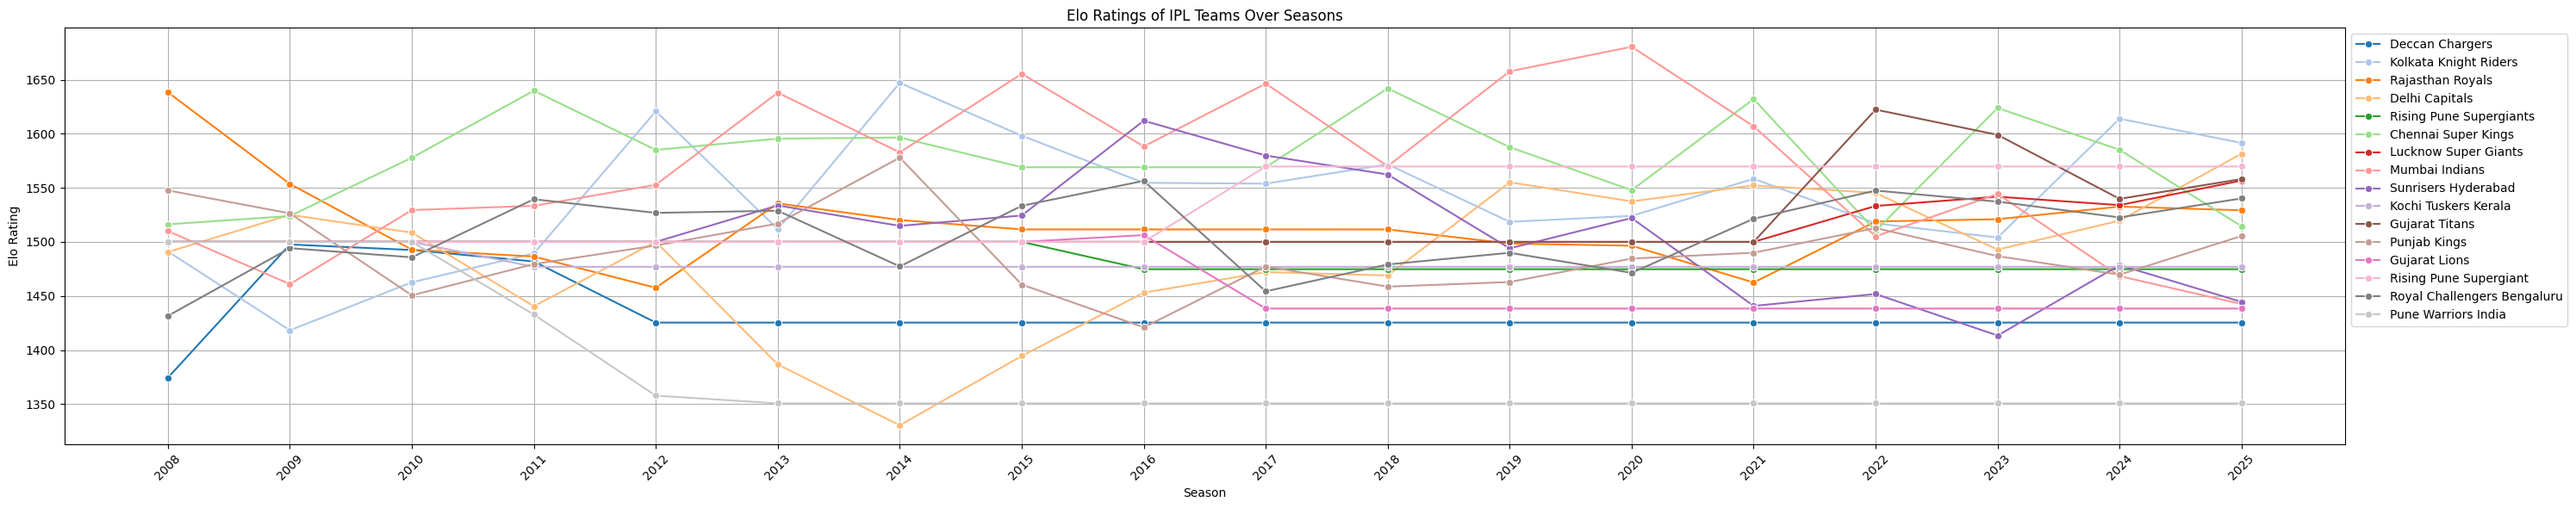

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (30,6))
sns.lineplot(data = elo_df,x = "season",y = "elo",hue = "team",marker = "o",palette = "tab20")

plt.title("Elo Ratings of IPL Teams Over Seasons")
plt.xlabel("Season")
plt.ylabel("Elo Rating")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.tight_layout()
plt.show()



# Subplots for each team

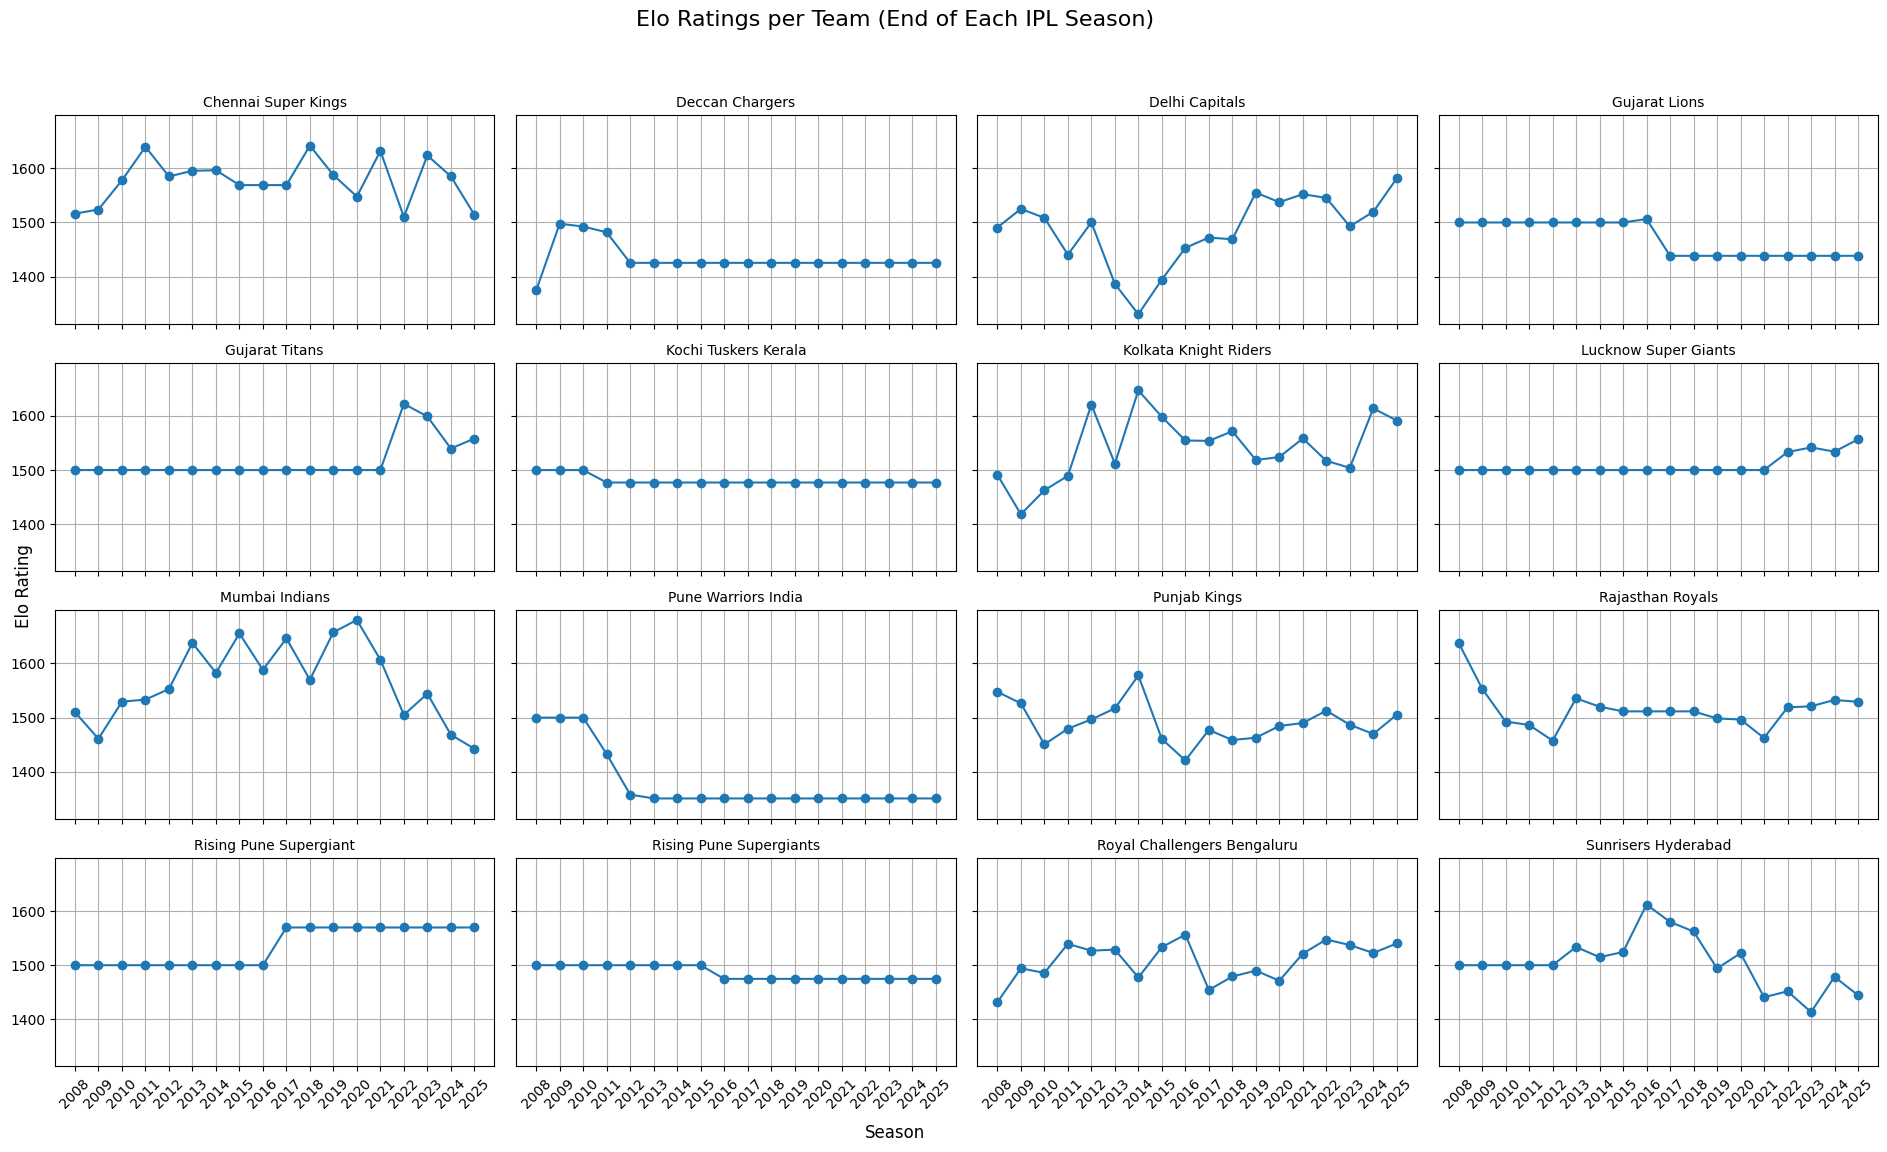

In [6]:
import math
teams = sorted(elo_df["team"].unique())
n_teams = len(teams)
n_cols = 4
n_rows = math.ceil(n_teams/n_cols)

fig,axes = plt.subplots(n_rows,n_cols,figsize=(20,n_rows*3),sharex=True,sharey=True)
axes = axes.flatten()

# Plot Elo progression for each team
for i, team in enumerate(teams):
    team_data = elo_df[elo_df["team"] == team]
    axes[i].plot(team_data["season"], team_data["elo"], marker='o', color='tab:blue')
    axes[i].set_title(team, fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Elo Ratings per Team (End of Each IPL Season)", fontsize=16)
fig.text(0.5, 0.04, 'Season', ha='center', fontsize=12)
fig.text(0.06, 0.5, 'Elo Rating', va='center', rotation='vertical', fontsize=12)
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()

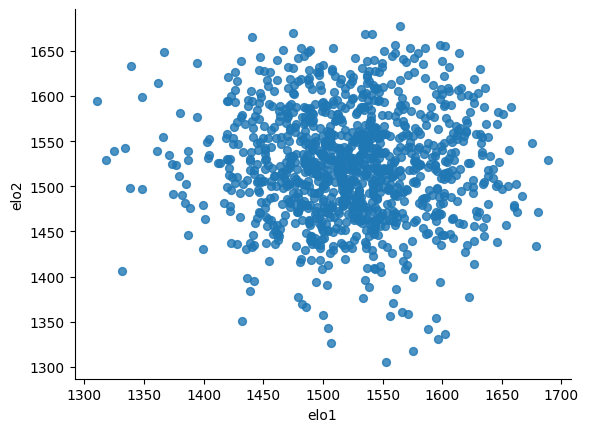

In [7]:
from matplotlib import pyplot as plt
df_elo.plot(kind='scatter', x='elo1', y='elo2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

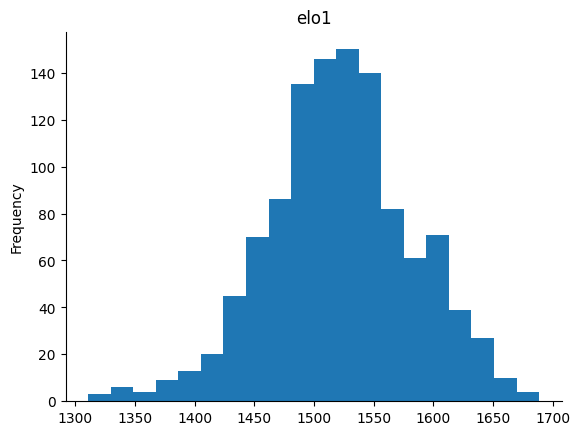

In [8]:
from matplotlib import pyplot as plt
df_elo['elo1'].plot(kind='hist', bins=20, title='elo1')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Train_Test_Split

In [9]:
df_eloX = df_elo.drop(columns=["win", "season", "elo1", "elo2", "team1", "team2"])
y = df_elo["win"]
X_train,X_test,y_train,y_test = train_test_split(df_eloX,y,test_size = 0.2,random_state = 42)

# Training XGBoost model

In [10]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_res,y_res = smote.fit_resample(X_train,y_train)
model = XGBClassifier(n_estimators=300,learning_rate=0.05,max_depth=6,random_state=42)
model.fit(X_res,y_res)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(f"model accuracy: {accuracy:.4f}")
print(classification_report(y_test,y_pred))


model accuracy: 0.8444
              precision    recall  f1-score   support

           0       0.87      0.80      0.84       111
           1       0.82      0.89      0.85       114

    accuracy                           0.84       225
   macro avg       0.85      0.84      0.84       225
weighted avg       0.85      0.84      0.84       225



# Function to predict_ipl_teams

In [11]:
def predict_ipl2025_top4(fixtures, model, elo, home_grounds, recent_perf, head_to_head,points_table):
    match_results = []
    for _, row in fixtures.iterrows():
        team1, team2, venue = row["team1"], row["team2"], row["venue"]
        R1, R2 = elo.get(team1, 1500), elo.get(team2, 1500)

        # Recent form
        team1_recent_win_pct = sum(recent_perf.get(team1, [])[-5:]) / max(1, min(len(recent_perf.get(team1, [])), 5))
        team2_recent_win_pct = sum(recent_perf.get(team2, [])[-5:]) / max(1, min(len(recent_perf.get(team2, [])), 5))

        # Head-to-head
        h2h_win_rate = 0
        if team2 in head_to_head.get(team1, {}):
            total_matches = head_to_head[team1][team2][1]
            if total_matches > 0:
                h2h_win_rate = head_to_head[team1][team2][0] / total_matches

        # Home ground
        home_advantage = 1 if venue == home_grounds.get(team1) else -1 if venue == home_grounds.get(team2) else 0

        # Prepare features and predict winner
        match_features = [[R1 - R2, team1_recent_win_pct, team2_recent_win_pct, h2h_win_rate, home_advantage]]
        winner_pred = model.predict(match_features)[0]

        if winner_pred == 1:
            winner, loser = team1, team2
            points_table[winner] += 2
        else:
            winner, loser = team2, team1
            points_table[winner] += 2

        match_results.append(winner)

        # Elo update
        E1 = 1 / (1 + 10 ** ((R2 - R1) / 400))
        S1 = 1 if winner_pred == 1 else 0
        K = 24 if home_advantage == 1 else 32

        elo[team1] += K * (S1 - E1)
        elo[team2] += K * ((1 - S1) - (1 - E1))

        # Update form
        recent_perf.setdefault(team1, []).append(S1)
        recent_perf.setdefault(team2, []).append(1 - S1)

        # Update head-to-head
        head_to_head.setdefault(team1, {}).setdefault(team2, [0, 0])
        head_to_head.setdefault(team2, {}).setdefault(team1, [0, 0])
        if winner == team1:
            head_to_head[team1][team2][0] += 1
        else:
            head_to_head[team2][team1][0] += 1
        head_to_head[team1][team2][1] += 1

    # Get top 4
    top_4 = sorted(points_table.items(),key=lambda x: x[1],reverse=True)[:4]
    return top_4, points_table,match_results


# Fixtures

In [12]:
import pandas as pd

fixtures = pd.DataFrame({
    "match_no": list(range(1, 71)),  # 70 league matches
    "date": [
        "22-Mar-25", "23-Mar-25", "23-Mar-25", "24-Mar-25", "25-Mar-25",
        "26-Mar-25", "27-Mar-25", "28-Mar-25", "29-Mar-25", "30-Mar-25",
        "30-Mar-25", "31-Mar-25", "01-Apr-25", "02-Apr-25", "03-Apr-25",
        "04-Apr-25", "05-Apr-25", "05-Apr-25", "06-Apr-25", "06-Apr-25",
        "07-Apr-25", "08-Apr-25", "09-Apr-25", "10-Apr-25", "11-Apr-25",
        "12-Apr-25", "12-Apr-25", "13-Apr-25", "13-Apr-25", "14-Apr-25",
        "15-Apr-25", "16-Apr-25", "17-Apr-25", "18-Apr-25", "19-Apr-25",
        "19-Apr-25", "20-Apr-25", "20-Apr-25", "21-Apr-25", "22-Apr-25",
        "23-Apr-25", "24-Apr-25", "25-Apr-25", "26-Apr-25", "27-Apr-25",
        "27-Apr-25", "28-Apr-25", "29-Apr-25", "30-Apr-25", "01-May-25",
        "02-May-25", "03-May-25", "04-May-25", "04-May-25", "05-May-25",
        "06-May-25", "07-May-25", "08-May-25", "09-May-25", "10-May-25",
        "11-May-25", "11-May-25", "12-May-25", "13-May-25", "14-May-25",
        "15-May-25", "16-May-25", "17-May-25", "18-May-25", "18-May-25"
    ],
    "team1": [
        "Royal Challengers Bengaluru", "Rajasthan Royals", "Mumbai Indians", "Lucknow Super Giants",
        "Punjab Kings", "Kolkata Knight Riders", "Lucknow Super Giants", "Royal Challengers Bengaluru",
        "Mumbai Indians", "Sunrisers Hyderabad", "Chennai Super Kings", "Kolkata Knight Riders",
        "Punjab Kings", "Gujarat Titans", "Sunrisers Hyderabad", "Mumbai Indians",
        "Delhi Capitals", "Rajasthan Royals", "Lucknow Super Giants", "Gujarat Titans",
        "Royal Challengers Bengaluru", "Chennai Super Kings", "Rajasthan Royals", "Delhi Capitals",
        "Kolkata Knight Riders", "Gujarat Titans", "Punjab Kings", "Royal Challengers Bengaluru",
        "Mumbai Indians", "Chennai Super Kings", "Kolkata Knight Riders", "Rajasthan Royals",
        "Sunrisers Hyderabad", "Punjab Kings", "Delhi Capitals", "Lucknow Super Giants",
        "Royal Challengers Bengaluru","Chennai Super Kings","Gujarat Titans","Delhi Capitals","Mumbai Indians",
        "Rajasthan Royals","Sunrisers Hyderabad","Punjab Kings","Lucknow Super Giants","Royal Challengers Bengaluru",
        "Gujarat Titans","Kolkata Knight Riders","Punjab Kings","Mumbai Indians","Sunrisers Hyderabad","Chennai Super Kings",
        "Rajasthan Royals","Lucknow Super Giants","Delhi Capitals","Gujarat Titans","Chennai Super Kings","Delhi Capitals","Royal Challengers Bengaluru" ,"Kolkata Knight Riders",
        "Mumbai Indians","Gujarat Titans","Rajasthan Royals","Sunrisers Hyderabad","Lucknow Super Giants","Delhi Capitals","Punjab Kings","Kolkata Knight Riders",
        "Chennai Super Kings","Sunrisers Hyderabad"
    ],
    "team2": [
        "Kolkata Knight Riders","Sunrisers Hyderabad","Chennai Super Kings","Delhi Capitals","Gujarat Titans","Rajasthan Royals",
        "Sunrisers Hyderabad" ,"Chennai Super Kings","Gujarat Titans","Delhi Capitals","Rajasthan Royals","Mumbai Indians",
        "Lucknow Super Giants","Royal Challengers Bengaluru","Kolkata Knight Riders","Lucknow Super Giants","Chennai Super Kings",
        "Punjab Kings","Kolkata Knight Riders","Sunrisers Hyderabad","Mumbai Indians","Punjab Kings","Gujarat Titans","Royal Challengers Bengaluru",
        "Chennai Super Kings","Lucknow Super Giants","Sunrisers Hyderabad","Rajasthan Royals","Delhi Capitals","Lucknow Super Giants","Punjab Kings",
        "Delhi Capitals","Mumbai Indians","Royal Challengers Bengaluru","Gujarat Titans","Rajasthan Royals","Punjab Kings","Mumbai Indians",
        "Kolkata Knight Riders","Lucknow Super Giants", "Sunrisers Hyderabad","Royal Challengers Bengaluru","Chennai Super Kings",
        "Kolkata Knight Riders","Mumbai Indians","Delhi Capitals","Rajasthan Royals","Delhi Capitals","Chennai Super Kings","Rajasthan Royals",
        "Gujarat Titans","Royal Challengers Bengaluru","Kolkata Knight Riders","Punjab Kings","Sunrisers Hyderabad","Mumbai Indians",
        "Kolkata Knight Riders","Punjab Kings","Lucknow Super Giants","Sunrisers Hyderabad","Punjab Kings","Delhi Capitals","Chennai Super Kings",
        "Royal Challengers Bengaluru","Gujarat Titans","Mumbai Indians","Rajasthan Royals","Royal Challengers Bengaluru","Gujarat Titans","Lucknow Super Giants"
    ],
    "venue": [
        "Kolkata", "Hyderabad", "Chennai", "Visakhapatnam", "Ahmedabad", "Guwahati",
        "Hyderabad", "Chennai", "Ahmedabad", "Visakhapatnam", "Guwahati", "Mumbai",
        "Lucknow", "Bengaluru", "Kolkata", "Lucknow", "Chennai", "New Chandigarh",
        "Kolkata", "Hyderabad", "Mumbai", "New Chandigarh", "Ahmedabad", "Bengaluru",
        "Chennai", "Lucknow", "Hyderabad", "Jaipur", "Delhi", "Lucknow", "New Chandigarh",
        "Delhi", "Mumbai", "Bengaluru", "Ahmedabad", "Jaipur", "New Chandigarh",
        "Mumbai", "Kolkata", "Lucknow", "Hyderabad", "Bengaluru", "Chennai",
        "Kolkata", "Mumbai", "Delhi", "Jaipur", "Delhi", "Chennai", "Jaipur",
        "Ahmedabad", "Bengaluru", "Kolkata", "Dharamshala", "Hyderabad", "Mumbai",
        "Kolkata", "Dharamshala", "Lucknow", "Hyderabad", "Dharamshala", "Delhi",
        "Chennai", "Bengaluru", "Ahmedabad", "Mumbai", "Jaipur", "Bengaluru",
        "Ahmedabad", "Lucknow"
    ]
})

print(fixtures.head())


   match_no       date                        team1                  team2  \
0         1  22-Mar-25  Royal Challengers Bengaluru  Kolkata Knight Riders   
1         2  23-Mar-25             Rajasthan Royals    Sunrisers Hyderabad   
2         3  23-Mar-25               Mumbai Indians    Chennai Super Kings   
3         4  24-Mar-25         Lucknow Super Giants         Delhi Capitals   
4         5  25-Mar-25                 Punjab Kings         Gujarat Titans   

           venue  
0        Kolkata  
1      Hyderabad  
2        Chennai  
3  Visakhapatnam  
4      Ahmedabad  


In [13]:
# Running the simulation
top_4, full_points_table,match_results = predict_ipl2025_top4(fixtures, model, elo, home_grounds, recent_perf, head_to_head)

# Displaying results
print("\n Predicted Top 4 IPL Teams 2025 ")
for i, (team,points) in enumerate(top_4, 1):
    print(f"{i}. {team} - {points} pts")

#Full table
print("\n Full Points Table:")
for team, pts in sorted(full_points_table.items(),key=lambda x: x[1],reverse=True):
    print(f"{team}: {pts} pts")


TypeError: predict_ipl2025_top4() missing 1 required positional argument: 'points_table'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_ipl_season(fixtures,match_results):
    plt.figure(figsize=(20,40))
    plt.title("IPL 2025 Season Match Results",fontsize=20)
    colors = {
        team: plt.cm.tab20(i/20) for i,team in enumerate(set(fixtures['team1']).union(set(fixtures['team2'])))
    }

    for idx,row in fixtures.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        winner = match_results[idx]
        label = f"{team1} vs {team2}"
        color = colors[winner]
        plt.barh(y=idx, width=1, left=0, color=color, edgecolor='black')
        plt.text(0.5, idx, f"{label}\nWinner: {winner}", va='center', ha='center', fontsize=8, color='white')

    # Legend
    patches = [mpatches.Patch(color=clr,label=team) for team, clr in colors.items()]
    plt.legend(handles=patches,bbox_to_anchor=(1.05,1),loc='upper left',title='Teams')

    plt.yticks(range(len(fixtures)),fixtures['date'],fontsize=8)
    plt.xlabel("Match",fontsize=12)
    plt.ylabel("Date",fontsize=12)
    plt.tight_layout()
    plt.grid(axis='y',linestyle='--',alpha=0.5)
    plt.gca().invert_yaxis()
    plt.show()

In [15]:
mid_fixtures = pd.DataFrame({
    "match_no": list(range(27, 71)),  # 70 league matches
    "date": [
        "12-Apr-25", "13-Apr-25", "13-Apr-25", "14-Apr-25",
        "15-Apr-25", "16-Apr-25", "17-Apr-25", "18-Apr-25", "19-Apr-25",
        "19-Apr-25", "20-Apr-25", "20-Apr-25", "21-Apr-25", "22-Apr-25",
        "23-Apr-25", "24-Apr-25", "25-Apr-25", "26-Apr-25", "27-Apr-25",
        "27-Apr-25", "28-Apr-25", "29-Apr-25", "30-Apr-25", "01-May-25",
        "02-May-25", "03-May-25", "04-May-25", "04-May-25", "05-May-25",
        "06-May-25", "07-May-25", "08-May-25", "09-May-25", "10-May-25",
        "11-May-25", "11-May-25", "12-May-25", "13-May-25", "14-May-25",
        "15-May-25", "16-May-25", "17-May-25", "18-May-25", "18-May-25"
    ],
    "team1": [
        "Punjab Kings", "Royal Challengers Bengaluru",
        "Mumbai Indians", "Chennai Super Kings", "Kolkata Knight Riders", "Rajasthan Royals",
        "Sunrisers Hyderabad", "Punjab Kings", "Delhi Capitals", "Lucknow Super Giants",
        "Royal Challengers Bengaluru","Chennai Super Kings","Gujarat Titans","Delhi Capitals","Mumbai Indians",
        "Rajasthan Royals","Sunrisers Hyderabad","Punjab Kings","Lucknow Super Giants","Royal Challengers Bengaluru",
        "Gujarat Titans","Kolkata Knight Riders","Punjab Kings","Mumbai Indians","Sunrisers Hyderabad","Chennai Super Kings",
        "Rajasthan Royals","Lucknow Super Giants","Delhi Capitals","Gujarat Titans","Chennai Super Kings","Delhi Capitals","Royal Challengers Bengaluru" ,"Kolkata Knight Riders",
        "Mumbai Indians","Gujarat Titans","Rajasthan Royals","Sunrisers Hyderabad","Lucknow Super Giants","Delhi Capitals","Punjab Kings","Kolkata Knight Riders",
        "Chennai Super Kings","Sunrisers Hyderabad"
    ],
    "team2": [
        "Sunrisers Hyderabad","Rajasthan Royals","Delhi Capitals","Lucknow Super Giants","Punjab Kings",
        "Delhi Capitals","Mumbai Indians","Royal Challengers Bengaluru","Gujarat Titans","Rajasthan Royals","Punjab Kings","Mumbai Indians",
        "Kolkata Knight Riders","Lucknow Super Giants", "Sunrisers Hyderabad","Royal Challengers Bengaluru","Chennai Super Kings",
        "Kolkata Knight Riders","Mumbai Indians","Delhi Capitals","Rajasthan Royals","Delhi Capitals","Chennai Super Kings","Rajasthan Royals",
        "Gujarat Titans","Royal Challengers Bengaluru","Kolkata Knight Riders","Punjab Kings","Sunrisers Hyderabad","Mumbai Indians",
        "Kolkata Knight Riders","Punjab Kings","Lucknow Super Giants","Sunrisers Hyderabad","Punjab Kings","Delhi Capitals","Chennai Super Kings",
        "Royal Challengers Bengaluru","Gujarat Titans","Mumbai Indians","Rajasthan Royals","Royal Challengers Bengaluru","Gujarat Titans","Lucknow Super Giants"
    ],
    "venue": [
        "Rajiv Gandhi International Stadium, Uppal, Hyderabad",  "Sawai Mansingh Stadium, Jaipur", "Arun Jaitley Stadium, Delhi", "Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow","Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh",
        "Arun Jaitley Stadium, Delhi", "Wankhede Stadium, Mumbai", "M Chinnaswamy Stadium, Bengaluru", "Narendra Modi Stadium, Ahmedabad","Sawai Mansingh Stadium, Jaipur", "Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh",
        "Wankhede Stadium, Mumbai", "Eden Gardens, Kolkata", "Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow",  "Rajiv Gandhi International Stadium, Uppal, Hyderabad","M Chinnaswamy Stadium, Bengaluru", "M. A. Chidambaram Stadium, Chennai",
        "Eden Gardens, Kolkata", "Wankhede Stadium, Mumbai", "Arun Jaitley Stadium, Delhi", "Sawai Mansingh Stadium, Jaipur", "Arun Jaitley Stadium, Delhi", "Chennai", "M. A. Chidambaram Stadium, Chennai",
        "Narendra Modi Stadium, Ahmedabad", "M Chinnaswamy Stadium, Bengaluru", "Eden Gardens, Kolkata", "Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh", "Rajiv Gandhi International Stadium, Uppal, Hyderabad", "Wankhede Stadium, Mumbai",
        "Eden Gardens, Kolkata", "Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh", "Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow", "Rajiv Gandhi International Stadium, Uppal, Hyderabad", "Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh", "Arun Jaitley Stadium, Delhi",
        "M. A. Chidambaram Stadium, Chennai", "M Chinnaswamy Stadium, Bengaluru", "Narendra Modi Stadium, Ahmedabad", "Wankhede Stadium, Mumbai", "Sawai Mansingh Stadium, Jaipur", "M Chinnaswamy Stadium, Bengaluru",
        "Narendra Modi Stadium, Ahmedabad", "Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow"
    ]
})
print(mid_fixtures.head())


   match_no       date                        team1                 team2  \
0        27  12-Apr-25                 Punjab Kings   Sunrisers Hyderabad   
1        28  13-Apr-25  Royal Challengers Bengaluru      Rajasthan Royals   
2        29  13-Apr-25               Mumbai Indians        Delhi Capitals   
3        30  14-Apr-25          Chennai Super Kings  Lucknow Super Giants   
4        31  15-Apr-25        Kolkata Knight Riders          Punjab Kings   

                                               venue  
0  Rajiv Gandhi International Stadium, Uppal, Hyd...  
1                     Sawai Mansingh Stadium, Jaipur  
2                        Arun Jaitley Stadium, Delhi  
3  Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...  
4  Punjab Cricket Association IS Bindra Stadium, ...  


In [16]:
points_table = {"Punjab Kings":6,"Royal Challengers Bengaluru":6,"Mumbai Indians":2, "Chennai Super Kings":2, "Kolkata Knight Riders":6, "Rajasthan Royals":4,"Sunrisers Hyderabad":2, "Delhi Capitals":8, "Lucknow Super Giants":8,"Gujarat Titans":8}
# Running the simulation
top_4, full_points_table,match_results = predict_ipl2025_top4(mid_fixtures,model,elo,home_grounds,recent_perf,head_to_head,points_table)

# Displaying results
print("\n Predicted Top 4 IPL Teams 2025 ")
for i, (team,points) in enumerate(top_4, 1):
    print(f"{i}. {team} - {points} pts")

#Full table
print("\n Full Points Table:")
for team, pts in sorted(full_points_table.items(),key=lambda x: x[1],reverse=True):
    print(f"{team}: {pts} pts")


 Predicted Top 4 IPL Teams 2025 
1. Delhi Capitals - 26 pts
2. Royal Challengers Bengaluru - 18 pts
3. Kolkata Knight Riders - 18 pts
4. Gujarat Titans - 16 pts

 Full Points Table:
Delhi Capitals: 26 pts
Royal Challengers Bengaluru: 18 pts
Kolkata Knight Riders: 18 pts
Gujarat Titans: 16 pts
Punjab Kings: 14 pts
Lucknow Super Giants: 14 pts
Chennai Super Kings: 10 pts
Mumbai Indians: 8 pts
Rajasthan Royals: 8 pts
Sunrisers Hyderabad: 8 pts


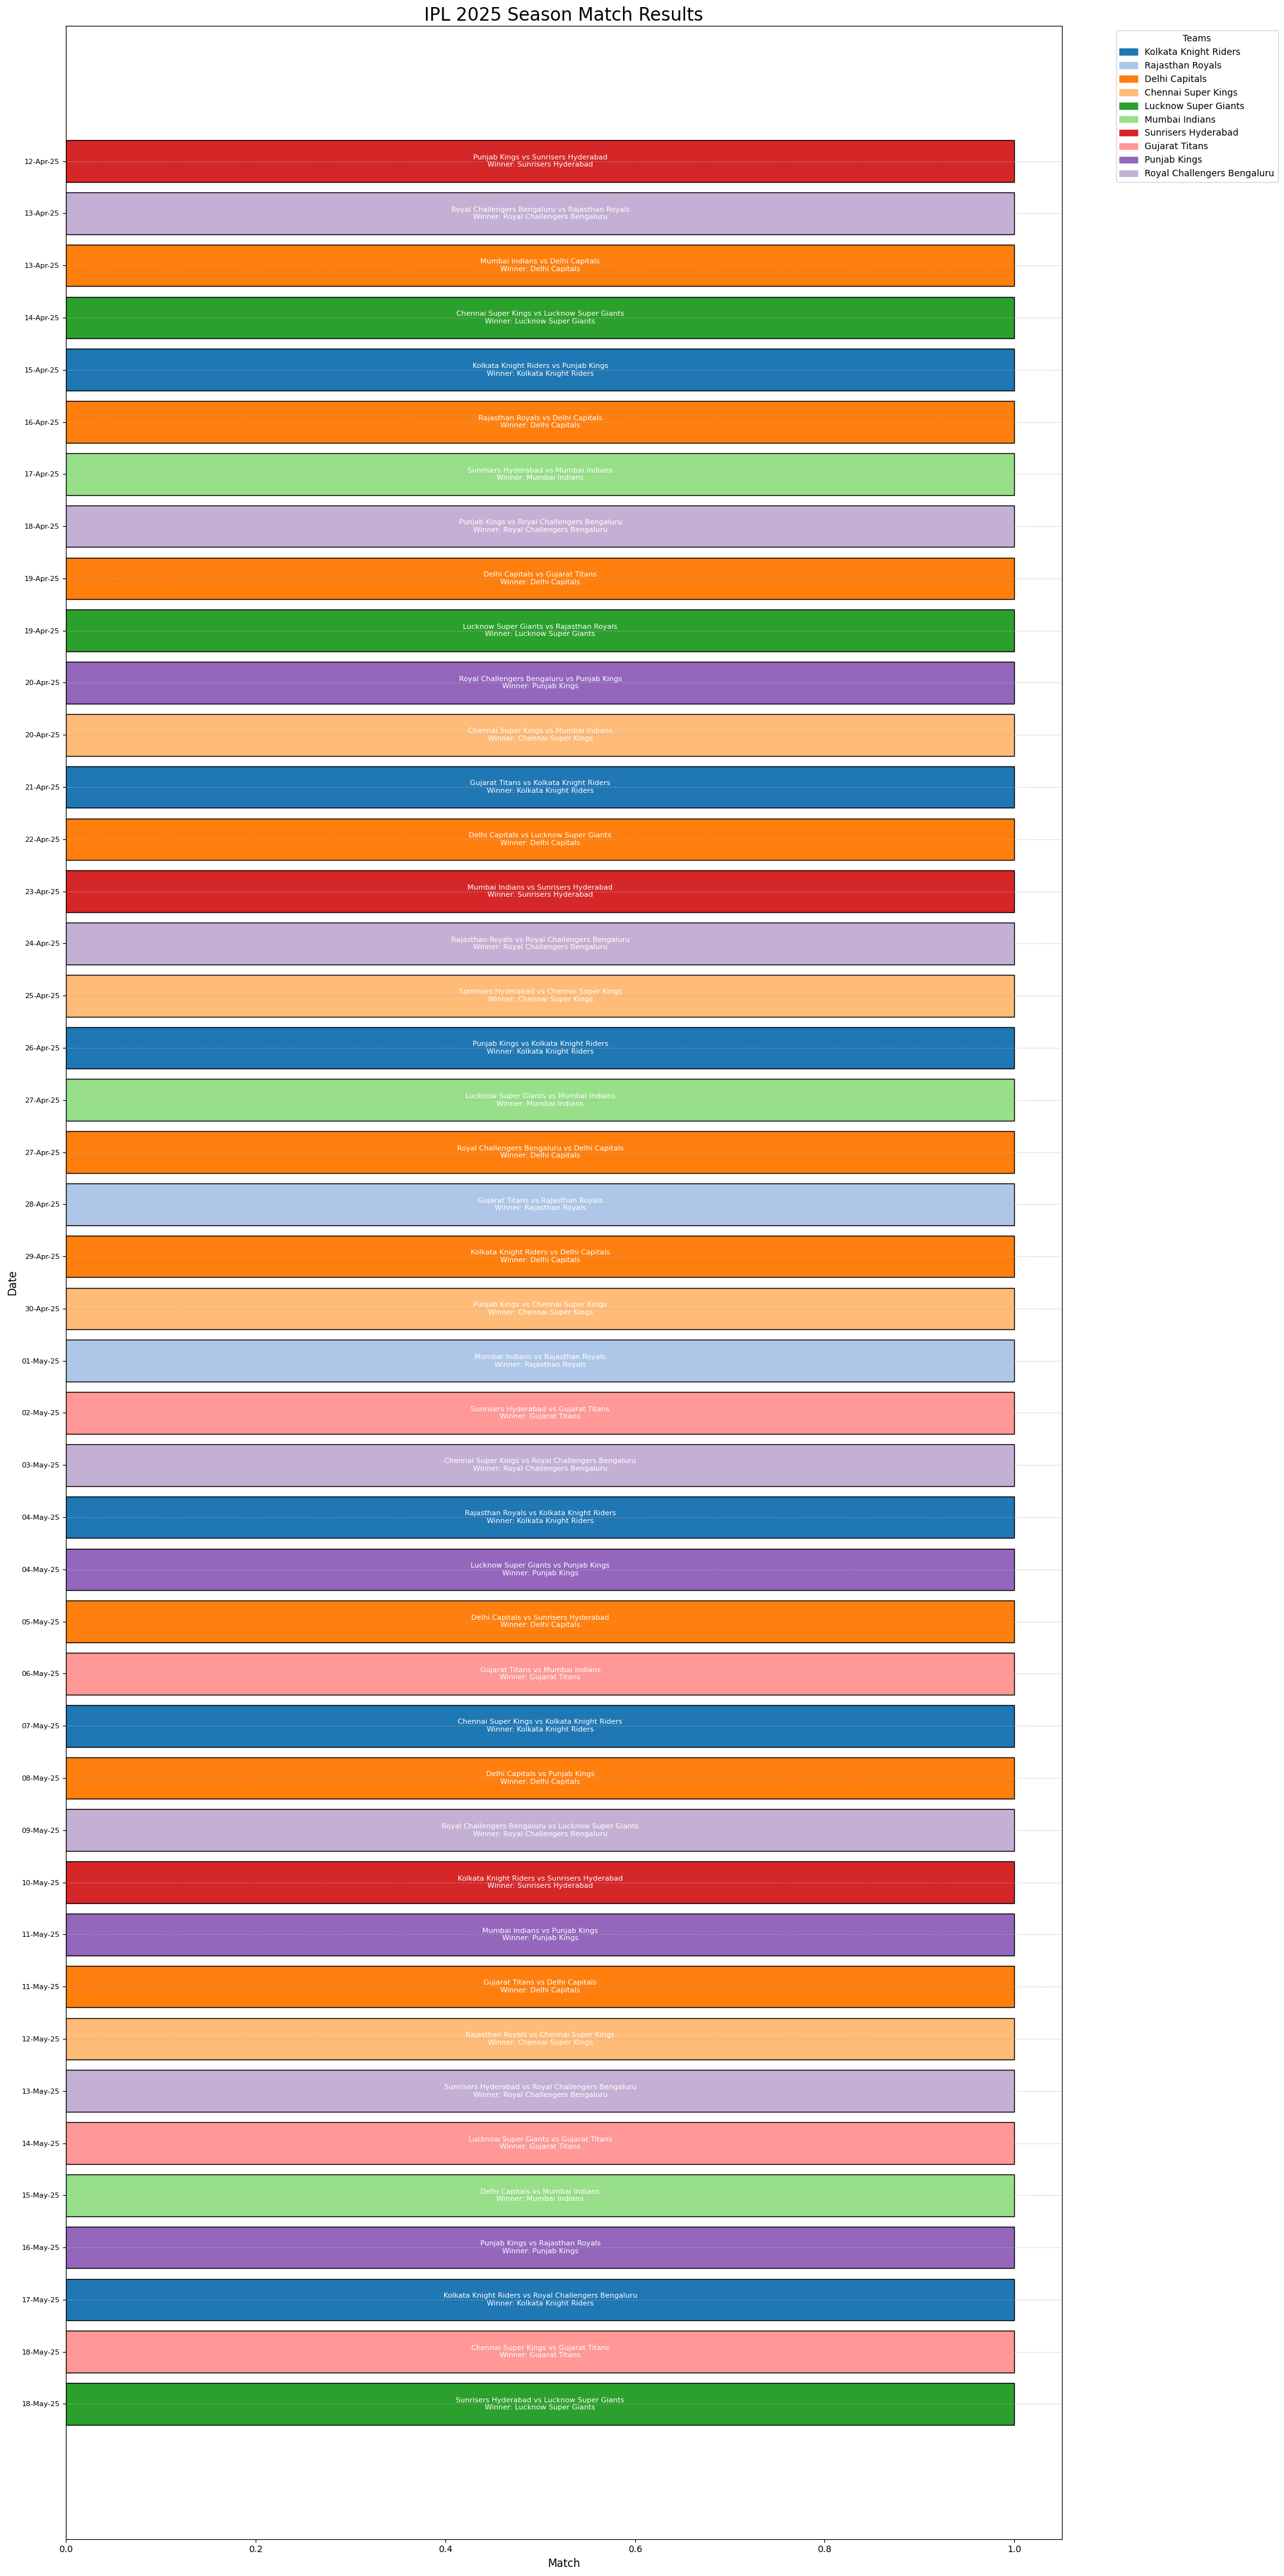

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_ipl_season(fixtures,match_results):
    plt.figure(figsize=(20,40))
    plt.title("IPL 2025 Season Match Results",fontsize=20)
    colors = {
        team: plt.cm.tab20(i/20) for i,team in enumerate(set(fixtures['team1']).union(set(fixtures['team2'])))
    }

    for idx,row in fixtures.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        winner = match_results[idx]
        label = f"{team1} vs {team2}"
        color = colors[winner]
        plt.barh(y=idx, width=1, left=0, color=color, edgecolor='black')
        plt.text(0.5, idx, f"{label}\nWinner: {winner}", va='center', ha='center', fontsize=8, color='white')

    # Legend
    patches = [mpatches.Patch(color=clr,label=team) for team, clr in colors.items()]
    plt.legend(handles=patches,bbox_to_anchor=(1.05,1),loc='upper left',title='Teams')

    plt.yticks(range(len(fixtures)),fixtures['date'],fontsize=8)
    plt.xlabel("Match",fontsize=12)
    plt.ylabel("Date",fontsize=12)
    plt.tight_layout()
    plt.grid(axis='y',linestyle='--',alpha=0.5)
    plt.gca().invert_yaxis()
    plt.show()
visualize_ipl_season(mid_fixtures,match_results)